In [2]:
!pip install statsmodels==0.13.1

     |████████████████████████████████| 9.8 MB 24.9 MB/s 
     |████████████████████████████████| 233 kB 97.4 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from statsmodels.tsa.arima.model import ARIMA

## Loading data

In [4]:
def csv_preprocessing_local():
    data_1 = pd.read_csv('ods001.csv', sep = ';')
    data_2 = pd.read_csv('ods034.csv', sep = ';')
    data_3 = pd.read_csv('ods035.csv', sep = ';')

    data_1.rename({'DateTime' : 'Datetime'}, axis = 1, inplace=True)
    data_2.rename({'Fuel code' : 'Fuel'}, axis = 1, inplace=True)

    result_data = pd.merge(data_2, data_3, on = ['Datetime', 'Fuel'])
    result_data = pd.merge(data_1, result_data, on = 'Datetime')
    result_data.Datetime = pd.to_datetime(result_data.Datetime)
    result_data.drop(['Resolution code', 'Resolution code_x', 'Resolution code_y'], axis = 1, inplace = True)
    result_data['Datetime'] = pd.to_datetime(result_data['Datetime'], utc=True)
    result_data.set_index('Datetime', inplace=True)

    f = open("input_data.csv", "w")

    result_data.to_csv('input_data.csv')

In [5]:
def data_loading_old():    
    url_dict = {}
    for year in range (2015, 2022):
        url_dict.update({f'url_{year}' : f'https://raw.githubusercontent.com/ishilov/DL-DIY/master/day_ahead_prices_{year}.csv'})

    train_data = pd.DataFrame([])

    for _, url in list(url_dict.items())[:-2]:
        train_data = pd.concat([train_data, pd.read_csv(url)]) if len(train_data) else pd.read_csv(url)

    test_data = pd.read_csv(url_dict['url_2020'])

    train_data['Datetime'] = pd.to_datetime(train_data['MTU (CET)'].astype(str).apply(lambda x: x[:16]), utc=True)
    test_data['Datetime'] = pd.to_datetime(test_data['MTU (CET)'].astype(str).apply(lambda x: x[:16]), utc=True)

    train_data.drop(['MTU (CET)'], axis = 1, inplace= True)
    test_data.drop(['MTU (CET)'], axis = 1, inplace= True)
    #train_data.set_index('Datetime', inplace= True)

    exogeneous_data = pd.read_csv('https://raw.githubusercontent.com/ishilov/DL-DIY/master/input_data.csv')
    date = pd.to_datetime('01.01.2020')

    date_2 = pd.to_datetime('01.01.2021')
    
    exogeneous_data['Datetime'] = pd.to_datetime(exogeneous_data['Datetime'])

    exogeneous_data.Datetime = exogeneous_data.Datetime.dt.tz_localize(None)
    train_data.Datetime = train_data.Datetime.dt.tz_localize(None)
    test_data.Datetime = test_data.Datetime.dt.tz_localize(None)

    exogeneous_train = exogeneous_data[exogeneous_data.Datetime < date]
    exogeneous_test = exogeneous_data[exogeneous_data.Datetime >= date]
    exogeneous_test = exogeneous_test[exogeneous_test.Datetime < date_2]

    #exogeneous_data.set_index('Datetime', inplace= True)

    train_data = pd.merge(exogeneous_train, train_data, on = 'Datetime')
    test_data = pd.merge(exogeneous_test, test_data, on = 'Datetime')

    return train_data, test_data

In [28]:
def data_loading():
    train_data_be_prices, test_data_be_prices = pd.DataFrame([]), pd.DataFrame([])
    train_data_fr_prices, test_data_fr_prices = pd.DataFrame([]), pd.DataFrame([])
    train_data_be_load, test_data_be_load = pd.DataFrame([]), pd.DataFrame([])
    train_data_be_generation, test_data_be_generation = pd.DataFrame([]), pd.DataFrame([])

    #first we load all the data from the github

    url_dict_be_prices, url_dict_fr_prices, url_dict_be_load, url_dict_be_generation  = {}, {}, {}, {}
    for year in range (2015, 2022):
        url_dict_be_prices.update({f'url_{year}' : f'https://raw.githubusercontent.com/ishilov/DL-DIY/master/day_ahead_prices_{year}.csv'})
        url_dict_fr_prices.update({f'url_{year}' : f'https://raw.githubusercontent.com/ishilov/DL-DIY/master/france_prices/Day_ahead_Prices_{year}_france.csv'})
        url_dict_be_load.update({f'url_{year}' : f'https://raw.githubusercontent.com/ishilov/DL-DIY/master/load_data_belgium/Total%20Load_Day%20Ahead_%20Actual_{year}.csv'})
        url_dict_be_generation.update({f'url_{year}' : f'https://raw.githubusercontent.com/ishilov/DL-DIY/master/actual_generation_belgium/Actual_Generation_per_Production_Type_{year}.csv'})

    #for the training dataset we take 2015-2019 (or 2020) and for the test 2020 (or 2021)
    #take the belgian prices
    for _, url in list(url_dict_be_prices.items())[:-2]:
        train_data_be_prices = pd.concat([train_data_be_prices, pd.read_csv(url)], ignore_index=True) if len(train_data_be_prices) else pd.read_csv(url)

    test_data_be_prices = pd.read_csv(url_dict_be_prices['url_2020'])

    train_data_be_prices['Datetime'] = pd.to_datetime(train_data_be_prices['MTU (CET)'].astype(str).apply(lambda x: x[:16]), utc=True)
    test_data_be_prices['Datetime'] = pd.to_datetime(test_data_be_prices['MTU (CET)'].astype(str).apply(lambda x: x[:16]), utc=True)

    train_data_be_prices.drop(['MTU (CET)'], axis = 1, inplace= True)
    test_data_be_prices.drop(['MTU (CET)'], axis = 1, inplace= True)

    train_data_be_prices.rename({'Day-ahead Price [EUR/MWh]' : 'Prices Belgium'}, axis = 1, inplace = True)
    test_data_be_prices.rename({'Day-ahead Price [EUR/MWh]' : 'Prices Belgium'}, axis = 1, inplace = True)

    #take the france prices
    for _, url in list(url_dict_fr_prices.items())[:-2]:
        train_data_fr_prices = pd.concat([train_data_fr_prices, pd.read_csv(url)], ignore_index=True) if len(train_data_fr_prices) else pd.read_csv(url)

    test_data_fr_prices = pd.read_csv(url_dict_fr_prices['url_2020'])

    train_data_fr_prices['Datetime'] = pd.to_datetime(train_data_fr_prices['MTU (CET)'].astype(str).apply(lambda x: x[:16]), utc=True)
    test_data_fr_prices['Datetime'] = pd.to_datetime(test_data_fr_prices['MTU (CET)'].astype(str).apply(lambda x: x[:16]), utc=True)

    train_data_fr_prices.drop(['MTU (CET)'], axis = 1, inplace= True)
    test_data_fr_prices.drop(['MTU (CET)'], axis = 1, inplace= True)

    train_data_fr_prices.rename({'Day-ahead Price [EUR/MWh]' : 'Prices France'}, axis = 1, inplace = True)
    test_data_fr_prices.rename({'Day-ahead Price [EUR/MWh]' : 'Prices France'}, axis = 1, inplace = True)

    #take belgian load
    for _, url in list(url_dict_be_load.items())[:-2]:
        train_data_be_load = pd.concat([train_data_be_load, pd.read_csv(url)], ignore_index=True) if len(train_data_be_load) else pd.read_csv(url)

    test_data_be_load = pd.read_csv(url_dict_be_load['url_2020'])

    train_data_be_load['Datetime'] = pd.to_datetime(train_data_be_load['Time (CET)'].astype(str).apply(lambda x: x[:16]), utc=True)
    test_data_be_load['Datetime'] = pd.to_datetime(test_data_be_load['Time (CET)'].astype(str).apply(lambda x: x[:16]), utc=True)

    train_data_be_load.drop(['Time (CET)'], axis = 1, inplace= True)
    test_data_be_load.drop(['Time (CET)'], axis = 1, inplace= True)

    #take_belgian_generation
    for _, url in list(url_dict_be_generation.items())[:-2]:
        train_data_be_generation = pd.concat([train_data_be_generation, pd.read_csv(url)], ignore_index=True) if len(train_data_be_generation) else pd.read_csv(url)

    test_data_be_generation = pd.read_csv(url_dict_be_generation['url_2020'])  

    train_data_be_generation['Datetime'] = pd.to_datetime(train_data_be_generation['MTU'].astype(str).apply(lambda x: x[:16]), utc=True)
    test_data_be_generation['Datetime'] = pd.to_datetime(test_data_be_generation['MTU'].astype(str).apply(lambda x: x[:16]), utc=True)

    train_data_be_generation.drop(['MTU'], axis = 1, inplace= True)
    test_data_be_generation.drop(['MTU'], axis = 1, inplace= True)

    #aggregating the load

    train_data_be_load = train_data_be_load.groupby(train_data_be_load.index // 4).sum()
    train_data_be_load['Datetime'] = train_data_be_generation.Datetime

    test_data_be_load = test_data_be_load.groupby(test_data_be_load.index // 4).sum()
    test_data_be_load['Datetime'] = test_data_be_generation.Datetime

    result_train = pd.merge(train_data_fr_prices, train_data_be_prices, on='Datetime')
    result_train = pd.merge(result_train, train_data_be_generation, on = 'Datetime')
    result_train = pd.merge(result_train, train_data_be_load, on = 'Datetime')

    result_test = pd.merge(test_data_fr_prices, test_data_be_prices, on='Datetime')
    result_test = pd.merge(result_test, test_data_be_generation, on = 'Datetime')
    result_test = pd.merge(result_test, test_data_be_load, on = 'Datetime')

    #last changes 
    result_train.drop(['BZN|FR', 'Area'], axis = 1, inplace = True)
    result_test.drop(['BZN|FR', 'Area'], axis = 1, inplace = True)

    empty_cols = ['Fossil Brown coal/Lignite  - Actual Aggregated [MW]', 'Fossil Coal-derived gas  - Actual Aggregated [MW]', 
                'Fossil Oil shale  - Actual Aggregated [MW]', 'Fossil Peat  - Actual Aggregated [MW]', 'Geothermal  - Actual Aggregated [MW]', 
                'Hydro Water Reservoir  - Actual Aggregated [MW]', 'Marine  - Actual Aggregated [MW]', 'Other renewable  - Actual Aggregated [MW]']

    result_train.drop(empty_cols, axis = 1, inplace = True)
    result_test.drop(empty_cols, axis = 1, inplace = True)

    result_train.dropna(axis=0, inplace = True)
    result_test.dropna(axis=0, inplace = True)

    train_data.replace('n/e', 0, inplace = True)
    test_data.replace('n/e', 0, inplace = True)

    return result_train, result_test



In [29]:
train_data, test_data = data_loading()

In [8]:
train_data

,Prices France,Datetime,Prices Belgium,Biomass - Actual Aggregated [MW],Fossil Gas - Actual Aggregated [MW],Fossil Hard coal - Actual Aggregated [MW],Fossil Oil - Actual Aggregated [MW],Hydro Pumped Storage - Actual Aggregated [MW],Hydro Pumped Storage - Actual Consumption [MW],Hydro Run-of-river and poundage - Actual Aggregated [MW],Nuclear - Actual Aggregated [MW],Other - Actual Aggregated [MW],Solar - Actual Aggregated [MW],Waste - Actual Aggregated [MW],Wind Offshore - Actual Aggregated [MW],Wind Onshore - Actual Aggregated [MW],Day-ahead Total Load Forecast [MW] - CTA|BE,Actual Total Load [MW] - CTA|BE
106,50.60,2015-05-01 10:00:00+00:00,50.60,225.0,3612.0,433.0,0.0,3.0,0.0,34.0,3909.0,755.0,310.0,264.0,235.0,289.0,46081.0,50508.0
111,43.10,2015-05-01 15:00:00+00:00,43.10,280.0,3667.0,436.0,0.0,25.0,0.0,38.0,3909.0,723.0,259.0,270.0,163.0,90.0,45938.0,49275.0
128,49.53,2015-06-01 08:00:00+00:00,49.53,274.0,3695.0,439.0,0.0,94.0,0.0,35.0,3905.0,758.0,0.0,266.0,90.0,256.0,45674.0,51865.0
137,48.55,2015-06-01 17:00:00+00:00,48.55,276.0,3560.0,437.0,0.0,67.0,0.0,40.0,3905.0,770.0,0.0,265.0,592.0,300.0,50534.0,54044.0
143,45.73,2015-06-01 23:00:00+00:00,45.73,279.0,2979.0,312.0,0.0,98.0,0.0,40.0,3899.0,719.0,0.0,262.0,272.0,218.0,44887.0,47134.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43867,36.46,2019-12-30 16:00:00+00:00,36.80,359.0,1652.0,n/e,0.0,3.0,117.0,29.0,5071.0,751.0,41.0,239.0,923.0,426.0,39832.0,38142.0
43871,40.60,2019-12-30 20:00:00+00:00,40.00,365.0,1684.0,n/e,0.0,64.0,0.0,30.0,5080.0,706.0,0.0,235.0,748.0,872.0,39307.0,39055.0
43884,42.15,2019-12-31 09:00:00+00:00,43.12,330.0,2045.0,n/e,0.0,51.0,0.0,27.0,4135.0,784.0,33.0,243.0,442.0,39.0,40820.0,41042.0
43889,38.00,2019-12-31 14:00:00+00:00,38.00,360.0,2049.0,n/e,0.0,13.0,0.0,31.0,4125.0,817.0,271.0,253.0,208.0,107.0,40373.0,41011.0


In [21]:
train_data.columns

Index(['Prices France', 'Datetime', 'Prices Belgium',
       'Biomass  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Consumption [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Nuclear  - Actual Aggregated [MW]', 'Other  - Actual Aggregated [MW]',
       'Solar  - Actual Aggregated [MW]', 'Waste  - Actual Aggregated [MW]',
       'Wind Offshore  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]',
       'Day-ahead Total Load Forecast [MW] - CTA|BE',
       'Actual Total Load [MW] - CTA|BE'],
      dtype='object')

In [25]:
def data_normalization(df, add_timestamp = False, test = False):
    transformer = preprocessing.MaxAbsScaler()
    cols = ['Prices France', 'Prices Belgium',
       'Biomass  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Consumption [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Nuclear  - Actual Aggregated [MW]', 'Other  - Actual Aggregated [MW]',
       'Solar  - Actual Aggregated [MW]', 'Waste  - Actual Aggregated [MW]',
       'Wind Offshore  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]',
       'Day-ahead Total Load Forecast [MW] - CTA|BE',
       'Actual Total Load [MW] - CTA|BE']
    transformed_data = transformer.fit_transform(train_data[cols])

    df_normalized = pd.DataFrame(transformed_data)
    df_normalized.columns = cols
    df_normalized.dropna(axis = 0, inplace = True)

    if add_timestamp == True:
        if test == True:
            df_normalized['Datetime'] = test_data.dropna(axis=0)['Datetime']
        else:
            df_normalized['Datetime'] = train_data.dropna(axis=0)['Datetime']
    #train_data_normalized.set_index('Datetime', inplace = True)

    return df_normalized

In [10]:
def encoding_datetime(df, save_datetime = False):
    df['year'] = df.Datetime.dt.year

    df['hr_sin'] = np.sin(df.Datetime.dt.hour*(2.*np.pi/24))
    df['hr_cos'] = np.cos(df.Datetime.dt.hour*(2.*np.pi/24))
    df['day_sin'] = np.sin((df.Datetime.dt.day-1)*(2.*np.pi/7))
    df['day_cos'] = np.cos((df.Datetime.dt.day-1)*(2.*np.pi/7))
    df['mnth_sin'] = np.sin((df.Datetime.dt.month-1)*(2.*np.pi/12))
    df['mnth_cos'] = np.cos((df.Datetime.dt.month-1)*(2.*np.pi/12))

    if not save_datetime:
        df.drop(['Datetime'], axis = 1, inplace = True)

    return df

In [39]:
def target_column_as_list(df):
    target_list = []
    features_list = []

    col = 'Prices Belgium'

    for value in df[col]:
        target_list.append(torch.tensor(value))

    if 'Datetime' in df.columns:
        df.drop('Datetime', axis =1, inplace = true)

    for index, row in df.loc[:, df.columns != col].iterrows():
        features_list.append(torch.from_numpy(row.values))

    return target_list, features_list

In [12]:
train_data.columns

Index(['Prices France', 'Datetime', 'Prices Belgium',
       'Biomass  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Consumption [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Nuclear  - Actual Aggregated [MW]', 'Other  - Actual Aggregated [MW]',
       'Solar  - Actual Aggregated [MW]', 'Waste  - Actual Aggregated [MW]',
       'Wind Offshore  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]',
       'Day-ahead Total Load Forecast [MW] - CTA|BE',
       'Actual Total Load [MW] - CTA|BE'],
      dtype='object')

<AxesSubplot:xlabel='Datetime', ylabel='Prices Belgium'>

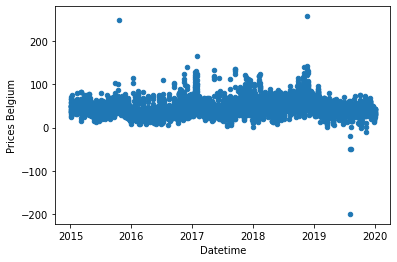

In [13]:
cols = ['Datetime', 'Prices Belgium']
plot_price = train_data[cols].drop_duplicates()
plot_price.plot.scatter('Datetime', 'Prices Belgium')

<AxesSubplot:xlabel='Datetime', ylabel='Prices Belgium'>

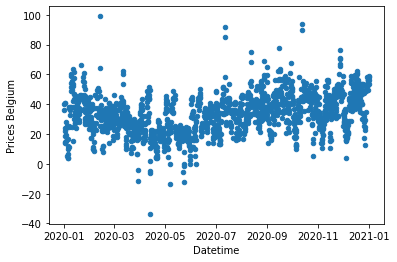

In [14]:
cols = ['Datetime', 'Prices Belgium']
plot_price = test_data[cols].drop_duplicates()
plot_price.plot.scatter('Datetime', 'Prices Belgium')

In [15]:
def cutting_outbreaks(df):
    pass

In [16]:
def data_aggregation(df, save_datetime = False, test=False):
    result = []

    if not test:
        df['Datetime'] = train_data.dropna(axis=0)['Datetime']
    else:
        df['Datetime'] = test_data.dropna(axis=0)['Datetime']

    cols_a = ['Datetime', 'Total Load', 'Total installed power','Day-ahead Price [EUR/MWh]', 
                'hr_sin', 'hr_cos', 'day_sin', 'day_cos', 'mnth_sin', 'mnth_cos']
    a = df[cols_a].drop_duplicates()

    cols_b = ['Installed Power', 'Day Ahead Generation Schedule', 'Datetime']
    if not test:
        b = df[cols_b].groupby(['Datetime']).sum().reset_index()
    else:
        b = df[cols_b].groupby(['Datetime']).sum().reset_index()


    df_aggregated = pd.merge(a, b, on= 'Datetime')

    if not save_datetime:
        df_aggregated.drop(['Datetime'], axis = 1, inplace = True)

    return df_aggregated

In [17]:
def to_list_of_tensors_old(df, train_data, test_data, aggregation = False, test=False):
    if aggregation == False:
        result = []
        for value in train_data_normalized['Day-ahead Price [EUR/MWh]'].unique():
            list_for_one_price = []
            for index, row in train_data_normalized.loc[train_data_normalized['Day-ahead Price [EUR/MWh]'] == value].iterrows():
                list_for_one_price.append(row.values)
            result.append(torch.from_numpy(np.array(list_for_one_price)))

    if aggregation == True:
        result = []
        if not test:
            df['Datetime'] = train_data.dropna(axis=0)['Datetime']
        else:
            df['Datetime'] = test_data.dropna(axis=0)['Datetime']

        cols_a = ['Datetime', 'Total Load', 'Total installed power','Day-ahead Price [EUR/MWh]', 
                    'hr_sin', 'hr_cos', 'day_sin', 'day_cos', 'mnth_sin', 'mnth_cos']
        a = df[cols_a].drop_duplicates()

        cols_b = ['Installed Power', 'Day Ahead Generation Schedule', 'Datetime']
        b = df[cols_b].groupby(['Datetime']).sum().reset_index()

        df_aggregated = pd.merge(a, b, on= 'Datetime').drop(['Datetime'], axis = 1)

        for index, row in df_aggregated.iterrows():
            result.append(torch.from_numpy(row.values))

    return result

In [31]:
def to_list_of_tensors(df):
    result = []

    if 'Datetime' in df.columns:
        df.drop('Datetime', axis = 1, inplace = True)

    for index, row in df.iterrows():
        result.append(torch.from_numpy(row.values))

    return result

In [34]:
def final_function():
    #first thing is to load all the data from the csv
    train_data, test_data = data_loading()

    #then we want to have the data to be normalized with datetime ecnoded
    train_data_normalized = encoding_datetime(data_normalization(train_data, add_timestamp=True))
    test_data_normalized = encoding_datetime(data_normalization(test_data, add_timestamp=True, test=True))

    #Now we have two normalized datasets with encoded datetime
    #We want to return aggregated versions of them as lists of tensors

    train_tensor_list = to_list_of_tensors(train_data_normalized)
    test_tensor_list = to_list_of_tensors(test_data_normalized)

    #we also want to have lists of features and target seprately for both train and test
    target_train, features_train = target_column_as_list(train_data_normalized)
    target_test, features_test = target_column_as_list(test_data_normalized)

    #target_train, features_train = target_column_as_list(data_aggregation(train_data_normalized, save_datetime=True))
    #target_test, features_test = target_column_as_list(data_aggregation(test_data_normalized, save_datetime=True, test=True))

    return {'train_data': train_data,
            'test_data' : test_data,
            'train_data_normalized': train_data_normalized,
            'test_data_normalized' : test_data_normalized,
            'train_tensor_list' : train_tensor_list,
            'test_tensor_list' : test_tensor_list,
            'target_train_tensor_list' : target_train,
            'features_train_tensor_list' : features_train,
            'target_test_tensor_list' : target_test,
            'features_test_tensor_list' : features_test}



In [40]:
data_dict = final_function()

## Network

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


In [ ]:
n1=239
n2=162
n_feature_columns=10

class DNN(nn.Module):
  def __init__(self):
    super(DNN, self).__init__()
    self.fc1 = nn.Linear(n_feature_columns,n1) #input number of columns in our table
    self.fc2 = nn.Linear(n1,n2)
    self.fc3 = nn.Linear(n2,24)
        # Change output to 48 dimensions if we include France as a neighbouring market

  def forward(self, x):
    x_1 = F.relu(self.fc1(x))
    x_2 = F.relu(self.fc2(x_1))
    return F.relu(self.fc3(x_2))

In [ ]:
class simpleDNN(nn.Module):
  def __init__(self):
    super(simpleDNN, self).__init__()
    self.fc1 = nn.Linear(n_feature_columns,n1) #input number of columns in our table
    self.fc2 = nn.Linear(n1,n2)
    self.fc3 = nn.Linear(n2,1)
        # Change output to 48 dimensions if we include France as a neighbouring market

  def forward(self, x):
    x_1 = F.relu(self.fc1(x))
    x_2 = F.relu(self.fc2(x_1))
    return F.relu(self.fc3(x_2))

In [ ]:
input_size=9
hidden_size=73
future_info_features=1
n_DNN=128
length_sequence=200
target_hours=1

class DNN_LSTM(nn.Module):
  def __init__(self):
    super(DNN_LSTM, self).__init__()
    self.lstm1=nn.LSTM(input_size=input_size, hidden_size=hidden_size) #input_size is the number of features, hidden_size is number of output features
    self.fc1 = nn.Linear(future_info_features,n_DNN)
    self.fc2 = nn.Linear(hidden_size*length_sequence+n_DNN,target_hours)

  def forward(self, past_sequence, future_info):
    x_1 = self.lstm1(torch.unsqueeze(past_sequence,1))
    #print(x_1[0])
    x_2 = F.relu(self.fc1(future_info))
    return F.relu(self.fc2(torch.cat((torch.flatten(x_1[0].squeeze()),x_2))))
  



In [ ]:
lr=0.0001
nb_epochs=10
model_sequential = DNN()
model_stochastic = DNN()
model_sequential = model_sequential.to(device)
model_stochastic = model_stochastic.to(device)
optimizer_sequential = torch.optim.Adam(model_sequential.parameters(),lr=lr)
optimizer_stochastic = torch.optim.Adam(model_stochastic.parameters(),lr=lr)
lstm_stochastic = DNN_LSTM()
lstm_stochastic.to(device)
lstm_optim_stochastic = torch.optim.Adam(lstm_stochastic.parameters(), lr=lr)
lstm_stochastic = DNN_LSTM()
lstm_stochastic.to(device)
lstm_optim_stochastic = torch.optim.Adam(lstm_stochastic.parameters(), lr=lr)

simple_model_sequential = simpleDNN()
simple_model_sequential.to(device)
simple_optim_sequential = torch.optim.Adam(simple_model_sequential.parameters(), lr=lr)

loss_fn = nn.L1Loss(reduction='mean')



In [ ]:
def construct_target(ind,target_list,target_number_hours):
  target= torch.FloatTensor(1, target_number_hours)
  for i in range(target_number_hours-1,-1,-1):
    #target[:,i-1]=tensor_list[ind-(25-i)][..., -1:].squeeze()
    #target[:,i]=tensor_list[ind+i][..., -1:].squeeze()
    target[:,target_number_hours-1-i]=target_list[ind+i].squeeze()
    #target[:,i]=target_list[ind-(24-i)].squeeze()
  return target.squeeze()

#print(construct_target(47,target))

In [ ]:
def c

In [ ]:
def construct_sequence(ind,length_sequence,past_features_indices_list,tensor_list):
  sequence=torch.FloatTensor(length_sequence,len(past_features_indices_list))
  for i in range(ind+1,ind+length_sequence+1):
    sequence[i-ind-1]=tensor_list[i][past_features_indices_list]
  return sequence
#print(construct_sequence(50,48,[0,1,2,3],data_dict['features_train_tensor_list']))

In [ ]:
stochastic_loss_list=[]
rng = np.random.default_rng()
def train_model_stochastic(model,loss_fn,training_input, training_target,epochs,optimizer):
  model.train(True)
  for epoch in range(epochs):
      for i in range(len(training_input)):
          ind=rng.integers(24, high=len(training_input)-24, size=None, dtype=np.int64, endpoint=False)
          optimizer.zero_grad()
          output=model(training_input[ind].float().to(device))
          target=construct_target(ind,training_target,24)
          loss = loss_fn(output, target.to(device))
          if i%100==0:
            stochastic_loss_list.append(loss)
          loss.backward()
          optimizer.step()

In [ ]:
sequential_loss_list=[]
def train_model_sequential(model,loss_fn,training_input,training_target,epochs,optimizer):
  model.train(True)
  for epoch in range(epochs) :
    for ind in range(len(training_input)-24,24,-1):
      optimizer.zero_grad()
      output=model(training_input[ind].float().to(device))
      #print(output)
      #print(output.size())
      #construct the target
      target=construct_target(ind,training_target,24)
      loss = loss_fn(output, target.to(device))
      
      

      if ind%100==0:
        sequential_loss_list.append(loss)
      loss.backward()
      optimizer.step()
      

In [ ]:
simple_sequential_loss_list=[]
def train_simple_model_sequential(model,loss_fn,training_input,training_target,epochs,optimizer):
  model.train(True)
  for epoch in range(epochs) :
    for ind in range(len(training_input)-24,24,-1):
      
      output=model(training_input[ind].float().to(device))
      #print(output)
      #print(output.size())
      #construct the target
      target=construct_target(ind,training_target,1)
      loss = loss_fn(output, target.to(device))
      optimizer.zero_grad()
      

      if ind%100==0:
        simple_sequential_loss_list.append(loss)
      loss.backward()
      optimizer.step()

In [ ]:

past_features_indices= [0,2,3,4,5,6,7,8,9]
future_indices= [1]
lstm_loss_list=[]
target_hours=1
rng = np.random.default_rng()

def train_lstm_stochastic(model,loss_fn,training_input,training_target,epochs,optimizer,length_sequence,past_features_indices,future_indices):
  model.train(True)
  for epoch in range(epochs):
      for i in range(len(training_input)):
          ind=rng.integers(24, high=len(training_input)-length_sequence-24, size=None, dtype=np.int64, endpoint=False)
          optimizer.zero_grad()
          output=model(construct_sequence(ind,length_sequence,past_features_indices,training_input).float().to(device),training_input[ind][future_indices].float().to(device))
          target=construct_target(ind,training_target,target_hours)
          loss = loss_fn(output, target.to(device))
          if i%100==0:
            lstm_loss_list.append(loss)
          loss.backward()
          optimizer.step()


In [ ]:
train_model_sequential(model_sequential,loss_fn,data_dict['features_train_tensor_list'],data_dict['target_train_tensor_list'],nb_epochs,simple_optim_sequential)

In [ ]:
train_simple_model_sequential(simple_model_sequential,loss_fn,data_dict['features_train_tensor_list'],data_dict['target_train_tensor_list'],nb_epochs,optimizer_sequential)

NameError: name 'simple_model_sequential' is not defined

In [ ]:
train_model_stochastic(model_stochastic,loss_fn,data_dict['features_train_tensor_list'], data_dict['target_train_tensor_list'], nb_epochs,optimizer_stochastic)

In [ ]:
train_lstm_stochastic(lstm_stochastic,loss_fn,data_dict['features_train_tensor_list'],data_dict['target_train_tensor_list'],nb_epochs,lstm_optim_stochastic,length_sequence,past_features_indices,future_indices)

[]
[tensor(0.1763, grad_fn=<L1LossBackward0>), tensor(0.1736, grad_fn=<L1LossBackward0>), tensor(0.1444, grad_fn=<L1LossBackward0>), tensor(0.1441, grad_fn=<L1LossBackward0>), tensor(0.1584, grad_fn=<L1LossBackward0>), tensor(0.1544, grad_fn=<L1LossBackward0>), tensor(0.1796, grad_fn=<L1LossBackward0>), tensor(0.1722, grad_fn=<L1LossBackward0>), tensor(0.1346, grad_fn=<L1LossBackward0>), tensor(0.1034, grad_fn=<L1LossBackward0>), tensor(0.1106, grad_fn=<L1LossBackward0>), tensor(0.0960, grad_fn=<L1LossBackward0>), tensor(0.1234, grad_fn=<L1LossBackward0>), tensor(0.1517, grad_fn=<L1LossBackward0>), tensor(0.1505, grad_fn=<L1LossBackward0>), tensor(0.1622, grad_fn=<L1LossBackward0>), tensor(0.1114, grad_fn=<L1LossBackward0>), tensor(0.1247, grad_fn=<L1LossBackward0>), tensor(0.2277, grad_fn=<L1LossBackward0>), tensor(0.1198, grad_fn=<L1LossBackward0>), tensor(0.1330, grad_fn=<L1LossBackward0>), tensor(0.1834, grad_fn=<L1LossBackward0>), tensor(0.1115, grad_fn=<L1LossBackward0>), tensor(

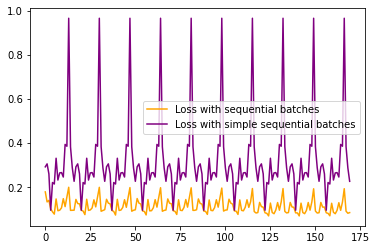

In [ ]:
plt.plot(range(len(sequential_loss_list)), sequential_loss_list, color='orange', label='Loss with sequential batches')
plt.plot(range(len(simple_sequential_loss_list)), simple_sequential_loss_list, color='purple', label='Loss with simple sequential batches')
print(stochastic_loss_list)
print(lstm_loss_list)
#plt.plot(range(len(stochastic_loss_list)), stochastic_loss_list, color='green', label='Loss with random batches')
#plt.plot(range(len(lstm_loss_list)), lstm_loss_list, color='red', label='Loss with lstm stochastic batches')

plt.legend()
plt.show()

## Arima Model

In [ ]:
mod = ARIMA(endog, order=(4, 1, 2))
res = mod.fit()
print(res.summary())

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ca6f955c-b181-41cc-a47f-43205351cbaf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>